Make a chart showing the running total of fatality crashes by year. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mtick
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

from datetime import datetime, timedelta
import pytz

import inflect
p = inflect.engine()

pd.set_option('display.max_rows', 100)

from crash_data_analysis import CrashDataAnalysis

In [2]:
cda = CrashDataAnalysis()

In [3]:
# Aggregate fatality crashes by year and day of year

query = """
select
crash_date
, crash_year
, crash_day_of_year
, count(*) as num_crashes
, sum(fatality::int) as deadly_crashes
, sum(case when pedestrian_ind > 0 then 1 else 0 end) as pedestrian_involved_crash
, sum(case when bicycle_ind > 0 then 1 else 0 end) as bicycle_involved_crash
, sum(case when fatality and pedestrian_ind > 0 then 1 else 0 end) as pedestrian_involved_fatality
, sum(case when fatality and bicycle_ind > 0 then 1 else 0 end) as bicycle_involved_fatality

from crashes

group by 1,2,3 order by 1
"""

crashes_by_day_of_year_long = pd.read_sql(query, cda.conn)

In [4]:
max_crash_timestamp = cda.most_recent_crash_timestamp()
max_day_of_year = max_crash_timestamp.day_of_year
this_year = max_crash_timestamp.year

deadly_crashes_this_year = crashes_by_day_of_year_long.loc[
    crashes_by_day_of_year_long.crash_year == this_year, 'deadly_crashes'
].sum()

num_crashes = pd.read_sql('select count(*) from crashes', cda.conn).iloc[0].values[0]

In [5]:
print(
    f"""Most recent crash (deadly or not) in database:
    {max_crash_timestamp.strftime('%a %b %-d, %-I:%M %p')} Mountain"""
)
print(f'Crashes in database: {num_crashes:,}')
print(f'Deadly crashes this year: {deadly_crashes_this_year}')

Most recent crash (deadly or not) in database:
    Thu Mar 23, 8:01 PM Mountain
Crashes in database: 227,736
Deadly crashes this year: 17


In [6]:
citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {max_crash_timestamp.strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

print(citation)


Source: City and County of Denver "Traffic Accidents" dataset, updated Mar 23, 2023
Chart by Devin Brady



In [7]:
# Aggregate fatality crashes by year and day of year

crashes_by_day_of_year = pd.pivot_table(
    data=crashes_by_day_of_year_long
    # , values='num_crashes'
    , values='deadly_crashes'
    # , values='pedestrian_involved_fatality'
    # , values='bicycle_involved_fatality'
#     , values='bicycle_involved_crash'
    , index='crash_day_of_year'
    , columns='crash_year'
    , aggfunc='sum'
    , fill_value=0
    )

In [8]:
# Ensure that every day of the year has a row in crashes_by_day_of_year
# If that row doesn't exist, fill it in with zeroes
for i in range(1,367):
    if not i in crashes_by_day_of_year.index:
        crashes_by_day_of_year.loc[i] = 0

In [9]:
crashes_by_day_of_year = crashes_by_day_of_year.sort_index()

# Mark the future dates of the current year as NULL so they don't show up on the graph
crashes_by_day_of_year.loc[(max_day_of_year+1):366, this_year] = pd.NA

running_total_crashes = crashes_by_day_of_year.cumsum()

In [10]:
# Determine the number of days in each year. 365 normally, 366 for leap years

years_in_data = sorted(crashes_by_day_of_year_long.crash_year.unique())
days_in_year = pd.Series(index=years_in_data, dtype=int)

for year in years_in_data:
    
    if year == this_year:
        days_in_year.loc[year] = max_day_of_year

    else:
        days_in_year.loc[year] = pd.Timestamp(year, 12, 31).dayofyear

# Series showing the total number of days in each year, for trendline chart
total_days_in_year = days_in_year.copy()
total_days_in_year.loc[this_year] = pd.Timestamp(this_year, 12, 31).dayofyear

In [11]:
# Make DataFrame with info about every month

first_of_month = pd.DataFrame({'month_int': range(1,13)})
first_of_month['month_str'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).strftime('%b'), axis=1)
first_of_month['day_of_year'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).day_of_year, axis=1)

first_of_month['label'] = first_of_month['month_str'] + '\n1'
first_of_month.loc[12, 'month_int'] = 13
first_of_month.loc[12, 'label'] = 'EOY'
first_of_month.loc[12, 'day_of_year'] = 366

In [12]:
fatality_crashes_by_year = crashes_by_day_of_year_long.groupby('crash_year').deadly_crashes.sum()

In [13]:
fatality_crash_per_day = fatality_crashes_by_year / days_in_year

projected_fatality_crashes_by_year = fatality_crashes_by_year.astype(float).copy()
projected_fatality_crashes_by_year[this_year] = (
    fatality_crash_per_day[this_year] * pd.Timestamp(this_year, 12, 31).dayofyear
)

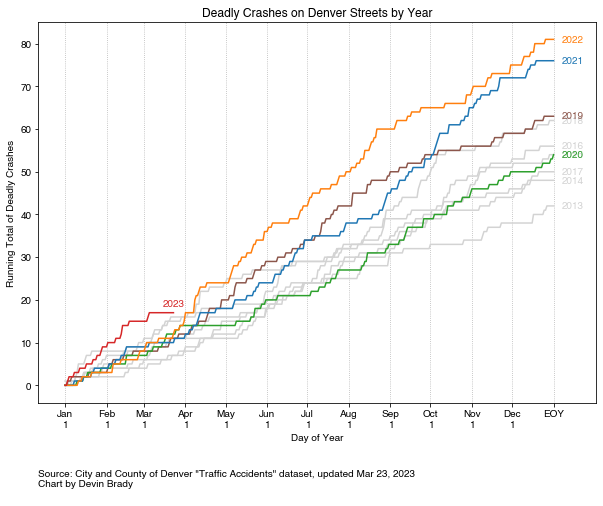

In [14]:
# Make the running total chart
fig, ax = plt.subplots(figsize=(10,7))

max_x_value = 380
plt.plot(range(0, max_x_value), [1] * max_x_value, alpha=0)

year_colors = {
    2019: 'tab:brown'
    , 2020: 'tab:green'
    , 2021: 'tab:blue'
    , 2022: 'tab:orange'
    , 2023: 'tab:red'
}

for year in years_in_data:
    if year in year_colors.keys():
        color = year_colors[year]
    else:
        color = 'lightgray'
        
    plt.plot(running_total_crashes[year], label=year, color=color)
    
    # trendline
#     plt.plot(
#         [0, total_days_in_year[year]]
#         , [0, projected_fatality_crashes_by_year[year]]
#         , color=color
#         , linestyle=':'
#     )
    
    if year == this_year:
        annotation_x = max_day_of_year
        annotation_y = max(running_total_crashes[year]) + 2
    else:
        annotation_x = max_x_value
        annotation_y = max(running_total_crashes[year])

    ax.annotate(
        xy=(annotation_x, annotation_y)
        , text=year
        , color=color
        , fontweight='bold'
        , horizontalalignment='center'
        , verticalalignment='center'
    )

    
plt.xticks(ticks=first_of_month['day_of_year'], labels=first_of_month['label'])
plt.grid(axis='x', linestyle=':')

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')
plt.xlabel('Day of Year')
plt.ylabel('Running Total of Deadly Crashes')
plt.title('Deadly Crashes on Denver Streets by Year')
_ = plt.savefig(
    'images/deadly_crashes_running_total.png', transparent=False, facecolor='white', bbox_inches='tight')

## Counts

In [15]:
fatality_crashes_by_year

crash_year
2013    42
2014    48
2015    54
2016    56
2017    50
2018    62
2019    63
2020    54
2021    76
2022    81
2023    17
Name: deadly_crashes, dtype: int64

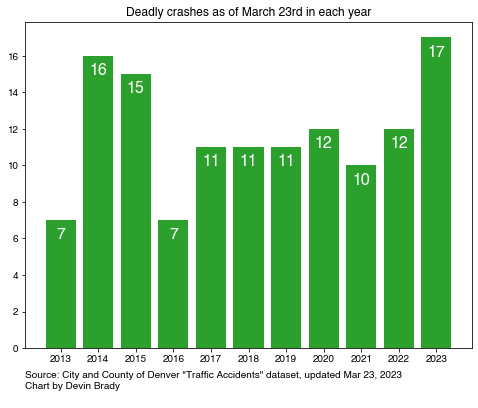

In [16]:
# Fatality crashes as of this day in the year
fig, ax = plt.subplots(figsize=(8,6))

crashes_at_this_point_in_year = running_total_crashes.loc[max_day_of_year]
ax.bar(
    x=crashes_at_this_point_in_year.index
    , height=crashes_at_this_point_in_year
    , color=TABLEAU_COLORS['tab:green']
)
ax.set_xticks(crashes_at_this_point_in_year.index)

transform_offset = mtransforms.offset_copy(ax.transData, fig=fig, x=0, y=-0.2, units='inches')

for year in years_in_data:
    plt.text(
        x=year
        , y=crashes_at_this_point_in_year[year]
        , s=crashes_at_this_point_in_year[year]
        , ha='center'
        , va='center'
        , color='white'
        , fontsize=16
        , fontweight='bold'
        , transform=transform_offset
    )

date_string = max_crash_timestamp.strftime('%B ')
date_string += p.ordinal(max_crash_timestamp.strftime('%-d'))

plt.title(f"Deadly crashes as of {date_string} in each year")

ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

plt.xlabel('')

_ = plt.savefig(
    'images/deadly_crashes_as_of_this_day_of_year.png', transparent=False, facecolor='white', bbox_inches='tight')

In [17]:
days_per_fatality_crash = days_in_year / fatality_crashes_by_year
days_per_fatality_crash

2013    8.690476
2014    7.604167
2015    6.759259
2016    6.535714
2017    7.300000
2018    5.887097
2019    5.793651
2020    6.777778
2021    4.802632
2022    4.506173
2023    4.823529
dtype: float64

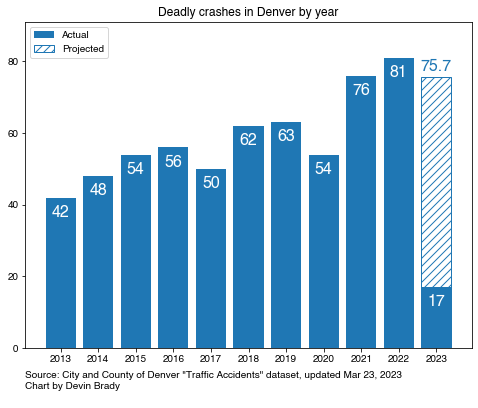

In [18]:
# Fatality crashes per year, current year projected
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(
    x=this_year
    , height=projected_fatality_crashes_by_year[this_year]
    , hatch='///'
    , fill=False
    , edgecolor=TABLEAU_COLORS['tab:blue']
    , label='Projected'
)

ax.bar(
    x=fatality_crashes_by_year.index
    , height=fatality_crashes_by_year
    , color=TABLEAU_COLORS['tab:blue']
    , label='Actual'
)

ax.set_xticks(fatality_crashes_by_year.index)

transform_offset = mtransforms.offset_copy(ax.transData, fig=fig, x=0, y=-0.2, units='inches')
transform_offset_proj = mtransforms.offset_copy(ax.transData, fig=fig, x=0, y=0.15, units='inches')

for year in years_in_data:
    plt.text(
        x=year
        , y=fatality_crashes_by_year[year]
        , s=fatality_crashes_by_year[year]
        , ha='center'
        , va='center'
        , color='white'
        , fontsize=16
        , fontweight='bold'
        , transform=transform_offset
    )

    if year == this_year:
        plt.text(
            x=year
            , y=projected_fatality_crashes_by_year[year]
            , s='{:.1f}'.format(projected_fatality_crashes_by_year[year])
            , ha='center'
            , va='center'
            , color=TABLEAU_COLORS['tab:blue']
            , fontsize=16
            , fontweight='bold'
            , transform=transform_offset_proj
        )

plt.ylim([0, max(fatality_crashes_by_year.max(), projected_fatality_crashes_by_year[this_year]) + 10])
# ax.tick_params(axis='x' ,direction='in', pad=-50, rotation=90, colors='white', labelsize=16)
# ax.xaxis.label.set_color('white')
# ax.tick_params(axis='x', rotation=90)
plt.title('Deadly crashes in Denver by year')

ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left')

_ = plt.savefig('images/deadly_crashes_barplot.png', transparent=False, facecolor='white', bbox_inches='tight')

## Deadly crashes as a percentage of all crashes

Is there deviation between these two metrics?

In [19]:
query = """
select
to_char(reported_date, 'YYYY-MM') as year_month
, count(*) as crashes
, sum(fatality::int) as deadly_crashes

from crashes

group by 1
order by 1
"""

monthly_crash_rate = pd.read_sql(query, cda.conn)

In [20]:
monthly_crash_rate['crashes_per_deadly_crash'] = monthly_crash_rate['crashes'] / monthly_crash_rate['deadly_crashes']
monthly_crash_rate['deadly_crash_perc'] = monthly_crash_rate['deadly_crashes'] / monthly_crash_rate['crashes']

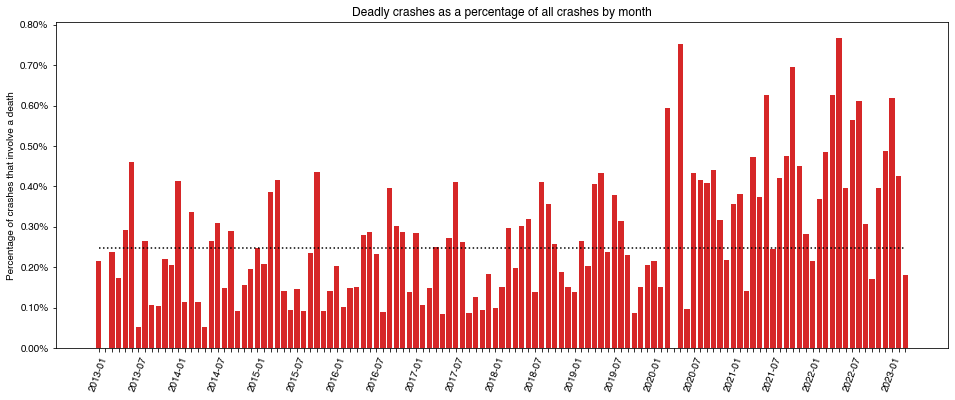

In [21]:
fig, ax = plt.subplots(figsize=(16,6))

data_to_plot = monthly_crash_rate.copy()
# data_to_plot = monthly_crash_rate.tail(24).copy()

ax.bar(
    x=data_to_plot['year_month']
    , height=data_to_plot['deadly_crash_perc']
    , color=TABLEAU_COLORS['tab:red']
)

ax.plot(
    [0, len(data_to_plot) - 1]
    , 2 * [data_to_plot['deadly_crash_perc'].median()]
    , color='black'
    , linestyle=':'
)

ax.tick_params(axis='x', rotation=70)

n = 6  # Keep every Nth label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.ylabel('Percentage of crashes that involve a death')
_ = plt.title('Deadly crashes as a percentage of all crashes by month')

## Year Thresholds

At what day in the current year are we matching the number of deadly crashes from previous years?

In [22]:
date_surpassed = pd.DataFrame(fatality_crashes_by_year)
date_surpassed.rename(columns={'fatality': 'deadly_crashes'}, inplace=True)
date_surpassed['date_surpassed_this_year'] = None

for year in date_surpassed.index:

    if date_surpassed.loc[this_year, 'deadly_crashes'] > date_surpassed.loc[year, 'deadly_crashes']:        
        day_of_year = int(
            running_total_crashes[
                running_total_crashes[this_year] > date_surpassed.loc[year, 'deadly_crashes']
            ].index.min()
        )
        date_this_year = (datetime(this_year, 1, 1) + timedelta(day_of_year - 1)).strftime('%B %-d, %Y')
        date_surpassed.loc[year, 'date_surpassed_this_year'] = date_this_year

date_surpassed.drop(index=this_year, inplace=True)
date_surpassed

,deadly_crashes,date_surpassed_this_year
crash_year,,
2013,42,None
2014,48,None
2015,54,None
2016,56,None
2017,50,None
2018,62,None
2019,63,None
2020,54,None
2021,76,None


## Recent deadly crashes

In [23]:
f = cda.recent_deadly_crashes()
f[['crash_time_str', 'pedestrian', 'bicycle', 'incident_address_corrected', 'neighborhood_id']].tail(20)

,crash_time_str,pedestrian,bicycle,incident_address_corrected,neighborhood_id
583,"Sun Dec 18, 2:23 PM",,x,N FEDERAL BLVD / W 35TH AVE,West Highland
584,"Sun Dec 18, 4:39 PM",x,,300 BLOCK N MEADE ST,Barnum
585,"Mon Dec 26, 10:21 PM",,,NB I25 TO EB I70 RAMP / N LINCOLN ST,Globeville
586,"Tue Jan 3, 1:28 AM",,,INTERSTATE 25 / E UNION AVE,Hampden South
587,"Wed Jan 4, 8:35 PM",,,N COLORADO BLVD / E 23RD AVE,City Park
588,"Sun Jan 8, 1:13 AM",x,,300 BLOCK N FEDERAL BLVD,Valverde
589,"Thu Jan 12, 3:44 PM",x,,E 29TH AVE / N COLORADO BLVD,Skyland
590,"Tue Jan 17, 12:59 AM",,,I270 HWYEB / N NORTHFIELD QUEBEC ST,Central Park
591,"Sun Jan 22, 1:54 AM",,,E BUCHTEL BLVD / S UNIVERSITY BLVD,University
592,"Wed Jan 25, 10:15 PM",x,,N TOWER RD / E 69TH AVE,DIA


## Alt text

In [24]:
print(
    'Line chart showing the running total for deadly crashes on Denver streets by year. '
    + f'The red line shows {this_year}, it is already above other years. '
)

Line chart showing the running total for deadly crashes on Denver streets by year. The red line shows 2023, it is already above other years. 


In [25]:
more_than_previous = deadly_crashes_this_year - max(
    crashes_at_this_point_in_year.loc[crashes_at_this_point_in_year.index != this_year]
)

print(
    'Bar chart showing the total number of deadly crashes as of this date in the year in Denver. '
    + f'In {this_year}, there have already been {deadly_crashes_this_year} deadly crashes, '
    + f'{more_than_previous} more than any previous year as of this date. '
)

Bar chart showing the total number of deadly crashes as of this date in the year in Denver. In 2023, there have already been 17 deadly crashes, 1 more than any previous year as of this date. 


In [26]:
print(
    f'Bar chart showing the total number of deadly crashes by year in Denver. {this_year} is projected to have ' 
    + f'{projected_fatality_crashes_by_year[this_year]:.1f} deadly crashes as of yesterday.'
     )

Bar chart showing the total number of deadly crashes by year in Denver. 2023 is projected to have 75.7 deadly crashes as of yesterday.


In [27]:
cda.conn.close()

In [28]:
# query = """
#     select
#     reported_date
#     , incident_address
#     , neighborhood_id
#     , crash_time_str

#     from crashes

#     where fatality
# """

# f = pd.read_sql(query, cda.conn)

In [29]:
# f['reported_dt'] = pd.to_datetime(f['reported_date'])

In [30]:
# f['days_between'] = (f['reported_date'] - f['reported_date'].shift(1)).dt.total_seconds() / 60 / 60 / 24

In [31]:
# f['rdt'] = pd.to_datetime('1900-01-01')

In [32]:

# for idx, row in f.iterrows():
#     f.loc[idx, 'rdt'] = pd.to_datetime(row['reported_date'])

In [33]:
# f.info()
CSS4_COLORS

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3